## Start the Project

### Tujuan
Mengimpor semua library yang diperlukan untuk mendukung manipulasi data, visualisasi, preprocessing teks, dan pembuatan model sistem rekomendasi.

### Library yang Digunakan
- `pandas` dan `numpy`: Untuk manipulasi dan analisis data.
- `matplotlib` dan `seaborn`: Untuk visualisasi data seperti bar chart.
- `wordcloud`: Untuk membuat visualisasi kata-kata umum dalam deskripsi.
- `sklearn`: Untuk pemrosesan teks (TF-IDF Vectorizer) dan perhitungan kesamaan (cosine similarity).
- `nltk`: Untuk preprocessing teks, seperti menghapus stop words.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
import string

In [2]:
# Download stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lapt1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Understanding

### Tujuan
Memahami struktur, isi, dan karakteristik dataset `netflix_titles.csv` untuk menentukan langkah-langkah persiapan data.

### Langkah-Langkah
- Memeriksa informasi dasar dataset (jumlah baris, kolom, tipe data).
- Mengidentifikasi missing values pada kolom penting seperti `description` dan `listed_in`.
- Membuat visualisasi:
- Bar chart untuk distribusi genre (`listed_in`).
- Word cloud untuk kata-kata umum dalam kolom `description`.

In [3]:
# Load dataset
df = pd.read_csv('netflix_titles.csv')

In [4]:
# Display basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [5]:
# Display missing values
df.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [6]:
# Check for duplicates
df.duplicated().sum()

0

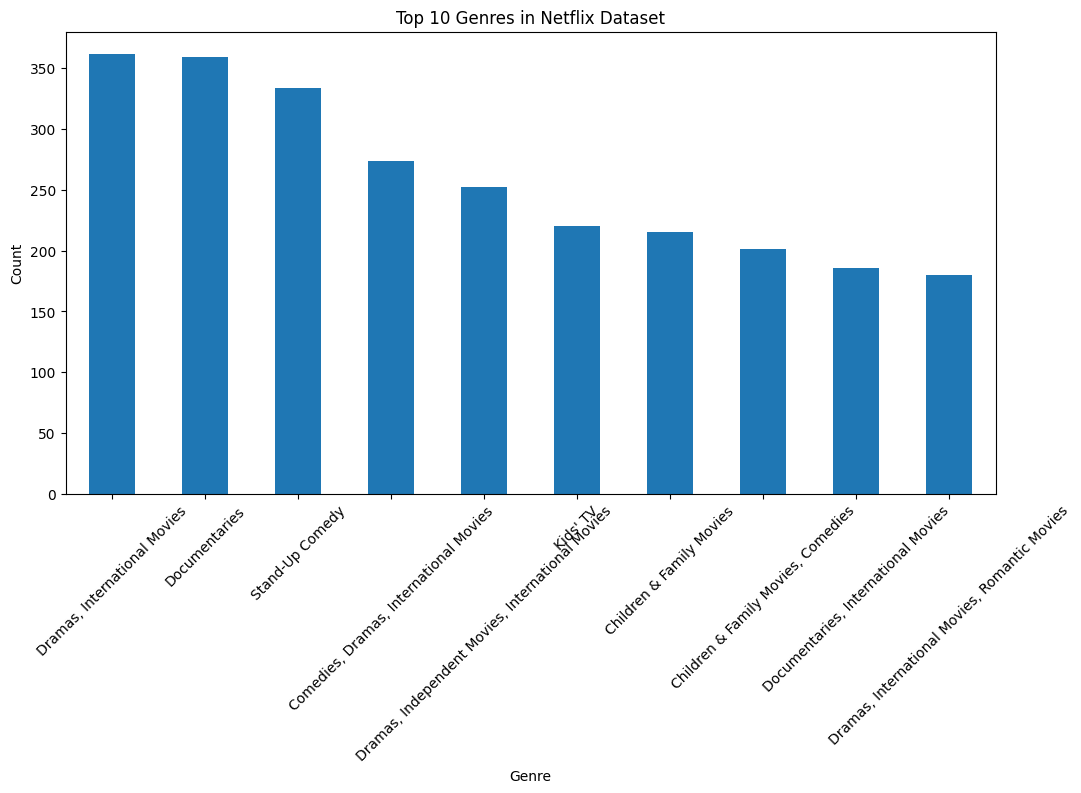

In [7]:
# Visualize genre distribution
plt.figure(figsize=(12, 6))
df['listed_in'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Genres in Netflix Dataset')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

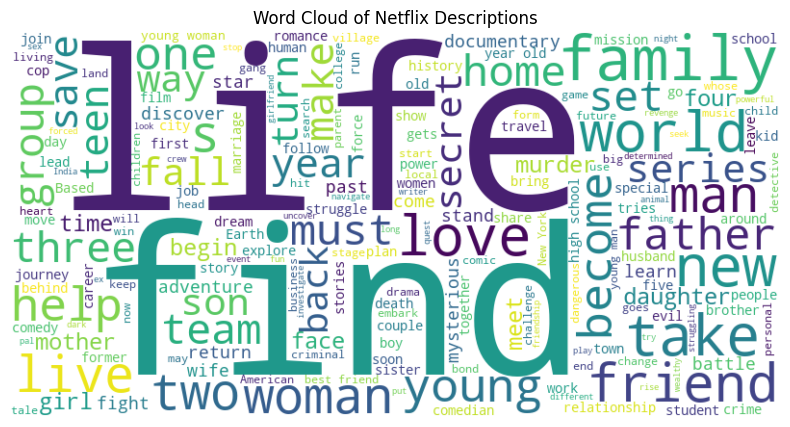

In [8]:
# Word cloud for descriptions
text = ' '.join(df['description'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Netflix Descriptions')
plt.show()

## Data Preparation

### Tujuan
Membersihkan dan mempersiapkan data agar siap digunakan untuk pemodelan sistem rekomendasi.

### Langkah-Langkah

Penanganan Missing Values
- Mengisi nilai kosong pada kolom `director`, `cast`, `country`, `date_added`, `rating`, dan `duration` dengan placeholder `"Unknown"`.
- Kolom `description` dan `listed_in` tidak memiliki missing values, sehingga tidak memerlukan penanganan khusus.

Penggabungan Fitur
- Menggabungkan kolom `description` dan `listed_in` untuk menciptakan fitur yang lebih kaya.

Preprocessing Teks
- Mengubah teks ke huruf kecil.
- Menghapus tanda baca.
- Menghilangkan stop words (kata umum seperti "the", "is").

In [ ]:
# Handle missing values
df['director'] = df['director'].fillna('Unknown')
df['cast'] = df['cast'].fillna('Unknown')
df['country'] = df['country'].fillna('Unknown')
df['date_added'] = df['date_added'].fillna('Unknown')
df['rating'] = df['rating'].fillna('Unknown')
df['duration'] = df['duration'].fillna('Unknown')

In [10]:
# Verify missing values after handling
df.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

In [11]:
# Combine description and listed_in for richer features
df['combined_features'] = df['description'] + ' ' + df['listed_in']

In [12]:
# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stop words
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [13]:
# Apply preprocessing
df['combined_features'] = df['combined_features'].apply(preprocess_text)

## Modeling

### Tujuan
Membangun sistem rekomendasi menggunakan pendekatan **Content-Based Filtering** berdasarkan kesamaan teks.

### Langkah-Langkah
- Menggunakan **TF-IDF Vectorizer** untuk mengubah teks (kombinasi `description` dan `listed_in`) menjadi vektor numerik.
- Menghitung **cosine similarity** untuk mengukur kesamaan antar film/TV show.
- Membuat fungsi rekomendasi yang menerima judul sebagai input dan mengembalikan daftar konten serupa.

In [14]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['combined_features'])

In [15]:
# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [16]:
# Recommendation function
def get_recommendations(title, cosine_sim=cosine_sim, df=df):
    try:
        idx = df[df['title'] == title].index[0]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:11]
        movie_indices = [i[0] for i in sim_scores]
        return df[['title', 'listed_in', 'description']].iloc[movie_indices]
    except:
        return "Title not found in dataset."

## Evaluation

### Tujuan
Menilai performa sistem rekomendasi secara kualitatif untuk memastikan rekomendasi yang dihasilkan relevan.

### Langkah-Langkah
- Menguji sistem dengan judul populer seperti "Squid Game" dan "Stranger Things".
- Menganalisis relevansi rekomendasi berdasarkan genre dan tema.
- Membandingkan hasil menggunakan kombinasi fitur (`description` + `listed_in`) dengan hanya menggunakan `description` untuk mengevaluasi dampak fitur tambahan.

In [17]:
# Test recommendations
print("\nRecommendations for 'Squid Game':")
print(get_recommendations('Squid Game'))


Recommendations for 'Squid Game':
                                  title  \
1011                       Free to Play   
3684                          Kakegurui   
2827                  The Circle Brazil   
1564                       Futmalls.com   
3037                     Medical Police   
3886                       Señora Acero   
1562                Alice in Borderland   
69       Stories by Rabindranath Tagore   
5411  Zipi & Zape y la Isla del Capitan   
1044                 High-Rise Invasion   

                                              listed_in  \
1011                                      Documentaries   
3684    International TV Shows, TV Dramas, TV Thrillers   
2827                 International TV Shows, Reality TV   
1564  Crime TV Shows, International TV Shows, TV Dramas   
3037  Crime TV Shows, TV Action & Adventure, TV Come...   
3886  Crime TV Shows, International TV Shows, Spanis...   
1562  International TV Shows, TV Action & Adventure,...   
69                 

In [18]:
print("\nRecommendations for 'Stranger Things':")
print(get_recommendations('Stranger Things'))


Recommendations for 'Stranger Things':
                            title  \
5888                Hemlock Grove   
1487              Sakho & Mangane   
3986                       The OA   
4320                    Neo Yokio   
6167  Anjaan: Special Crimes Unit   
2303                  Warrior Nun   
241                      Manifest   
6941                        Haven   
5388                           46   
1875      Do Do Sol Sol La La Sol   

                                              listed_in  \
5888              TV Horror, TV Mysteries, TV Thrillers   
1487  Crime TV Shows, International TV Shows, TV Dramas   
3986       TV Dramas, TV Mysteries, TV Sci-Fi & Fantasy   
4320    TV Comedies, TV Sci-Fi & Fantasy, Teen TV Shows   
6167    International TV Shows, TV Horror, TV Mysteries   
2303  TV Action & Adventure, TV Mysteries, TV Sci-Fi...   
241        TV Dramas, TV Mysteries, TV Sci-Fi & Fantasy   
6941         Classic & Cult TV, TV Horror, TV Mysteries   
5388    International

In [19]:
# Additional Experiment: Using only description
tfidf_desc = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix_desc = tfidf_desc.fit_transform(df['description'])
cosine_sim_desc = cosine_similarity(tfidf_matrix_desc, tfidf_matrix_desc)

In [20]:
print("\nRecommendations for 'Squid Game' (using only description):")
def get_recommendations_desc(title, cosine_sim=cosine_sim_desc, df=df):
    try:
        idx = df[df['title'] == title].index[0]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:11]
        movie_indices = [i[0] for i in sim_scores]
        return df[['title', 'listed_in', 'description']].iloc[movie_indices]
    except:
        return "Title not found in dataset."

print(get_recommendations_desc('Squid Game'))


Recommendations for 'Squid Game' (using only description):
                                                title  \
1011                                     Free to Play   
4789                                   King of Peking   
1615                                       Ink Master   
1440                                Nailed It! Mexico   
8479  The Redeemed and the Dominant: Fittest on Earth   
5903                                            Creep   
2827                                The Circle Brazil   
5411                Zipi & Zape y la Isla del Capitan   
2914                                       Isi & Ossi   
2591                                   The Half Of It   

                                              listed_in  \
1011                                      Documentaries   
4789             Comedies, Dramas, International Movies   
1615                                         Reality TV   
1440  International TV Shows, Reality TV, Spanish-La...   
8479             

## Testing

### Tujuan
Menguji robustitas sistem rekomendasi dengan lebih banyak judul untuk memastikan konsistensi dan relevansi.

### Langkah-Langkah
- Menguji sistem dengan judul tambahan seperti "The Queen's Gambit" dan "Breaking Bad".
- Menganalisis hasil rekomendasi untuk memverifikasi bahwa sistem dapat menangani berbagai jenis konten (film dan TV show) dengan baik.

In [21]:
# Test additional titles
print("\nRecommendations for 'The Queen's Gambit':")
print(get_recommendations("The Queen's Gambit"))


Recommendations for 'The Queen's Gambit':
                              title  \
7964    Searching for Bobby Fischer   
4507                          Sanju   
6794                     Frances Ha   
5184                  Akulah Balqis   
7134  Joe Cocker: Mad Dog with Soul   
245     Korean Cold Noodle Rhapsody   
5488   All Hail King Julien: Exiled   
2666                       #blackAF   
217               The Dirty Picture   
5736                       Pup Star   

                                              listed_in  \
7964   Children & Family Movies, Classic Movies, Dramas   
4507                       Dramas, International Movies   
6794               Comedies, Dramas, Independent Movies   
5184                  International TV Shows, TV Dramas   
7134  Documentaries, International Movies, Music & M...   
245                  Docuseries, International TV Shows   
5488       Kids' TV, TV Action & Adventure, TV Comedies   
2666                                        TV Comedies

In [22]:
print("\nRecommendations for 'Breaking Bad':")
print(get_recommendations('Breaking Bad'))


Recommendations for 'Breaking Bad':
                                          title  \
5352  Have You Ever Fallen in Love, Miss Jiang?   
1559                  The Mess You Leave Behind   
1564                               Futmalls.com   
4118                                Iron Ladies   
2606                            Extracurricular   
2388                              Alexa & Katie   
7447                                      Merlí   
4178                      Marvel's The Punisher   
1067                             The Underclass   
385             How to Sell Drugs Online (Fast)   

                                              listed_in  \
5352  Crime TV Shows, International TV Shows, TV Dramas   
1559  International TV Shows, Spanish-Language TV Sh...   
1564  Crime TV Shows, International TV Shows, TV Dramas   
4118  International TV Shows, Romantic TV Shows, TV ...   
2606  Crime TV Shows, International TV Shows, Korean...   
2388                              Kids' TV, TV 